# KMeans with two different datasets
I don't understand why KMeans algorithm performance changes so drastically when trained with the same dataset but other subset of data

In [1]:
import os
import argparse
import pickle
import os.path 
import pandas as pd
import numpy as np
from tqdm import tqdm
from benchtools.src.clustering import build_features
from benchtools.src.datatools import separate_data
from math import ceil
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline

import matplotlib.pyplot as plt

# Importing the classifiers
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier
from sklearn.cluster import KMeans

# tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Model

from benchtools.src.plotools import bkg_sig_hist
from benchtools.src.metrictools import optimal_threshold, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

## Getting the data

I have almost have of the data pre-processed in the following file

In [2]:
# Importing the data 
df = pd.read_csv("..\data\RD_dataset.csv")
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,m_jj,deltaR_j12,n_hadrons,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,2580.489568,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,3859.315047,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,2480.769725,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,2609.893413,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,3313.488835,3.629229,169.0,1.0


In [3]:
df.shape

(512000, 18)

I have been doing a sample of 100,000 events to use on the notebooks

In [4]:
df_RD = df.sample(100000, random_state = 1).drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_RD.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
264511,1636.540865,0.224496,-2.373993,1729.163350,0.371356,118,1547.619954,1.162014,0.710714,2722.719214,0.377317,59,3.224028,228.0,0.0
446040,1700.570450,-1.046567,-0.074009,2722.693611,0.173263,20,1471.042986,-0.496909,-3.102066,1660.217227,0.931903,39,3.077540,89.0,1.0
367350,1209.240264,1.501579,3.008941,2849.555797,0.693441,20,1192.250774,1.114281,-0.051151,2015.636945,0.527644,33,3.084503,86.0,0.0
510497,1331.228201,0.991312,2.934796,2041.150095,0.746076,13,1206.745736,0.501046,-0.197147,1366.214578,0.967665,54,3.170083,122.0,0.0
301480,1229.918669,-0.947064,2.870159,1828.159257,0.918211,39,1226.020830,0.063516,-0.261698,1238.924198,0.873326,42,3.290866,109.0,0.0


In [5]:
df_RD.shape

(100000, 15)

However, I have another dataset of 100,000 events

In [6]:
df_test = pd.read_csv("..\data\\test.csv").drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
df_test.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrons_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrons_j2,deltaR_j12,n_hadrons,label
0,1286.727685,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,0.064989,0.393688,1287.481934,0.713248,33,3.159663,109.0,0.0
1,1354.394070,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,-0.874319,-1.786248,1916.370744,0.276881,97,3.581406,208.0,0.0
2,1214.955723,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,0.143831,-1.090330,1089.530630,0.726963,59,3.149348,196.0,0.0
3,1285.227873,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,0.294854,-0.322661,1285.618789,0.706361,89,3.298155,183.0,0.0
4,1210.415787,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,1.060534,0.264977,1772.340209,0.787662,57,3.629229,169.0,1.0


In [7]:
df_test.shape

(100000, 15)

Both have similar distributions since they are from the same dataset

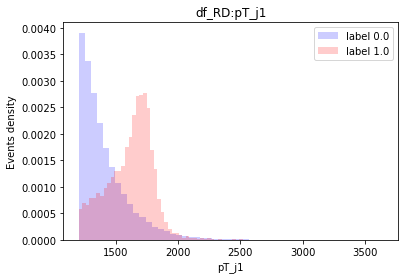

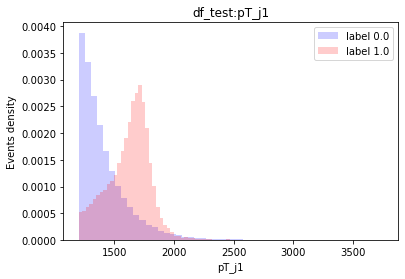

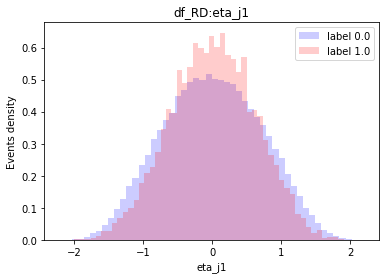

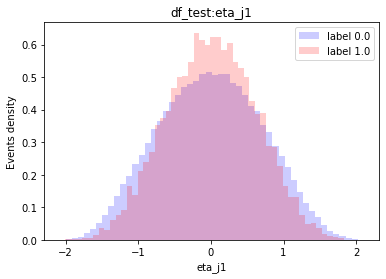

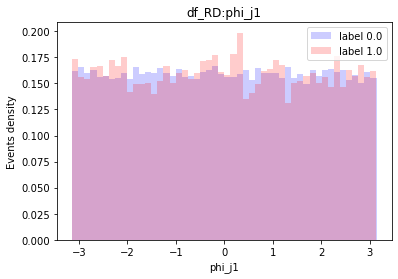

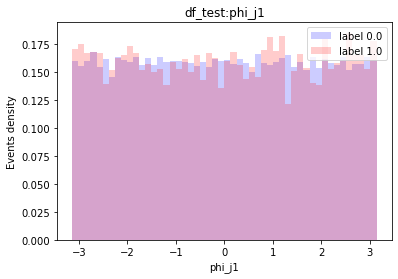

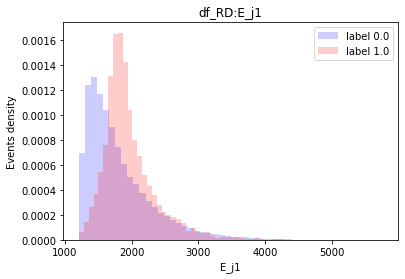

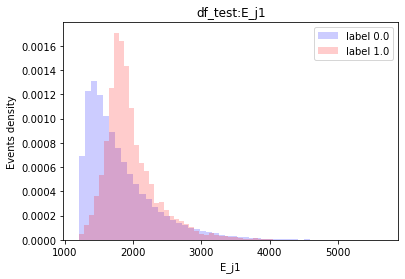

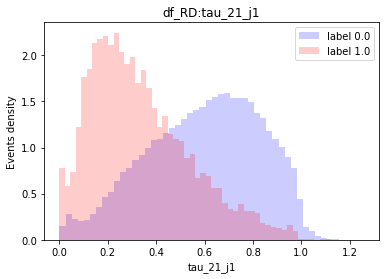

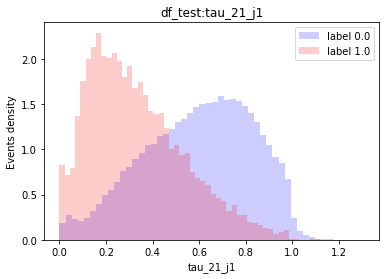

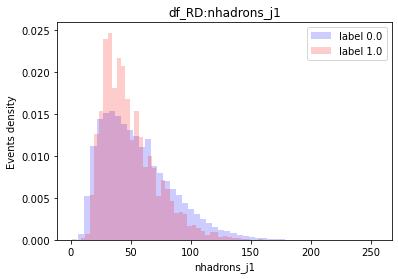

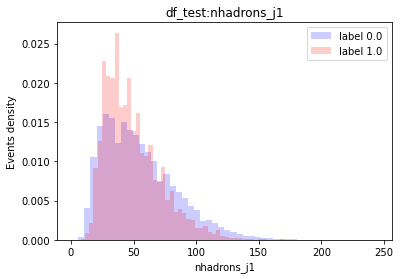

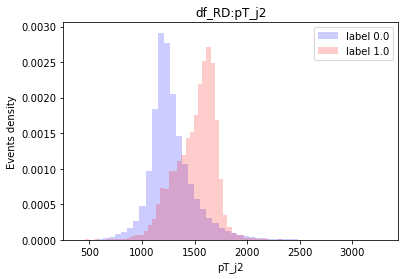

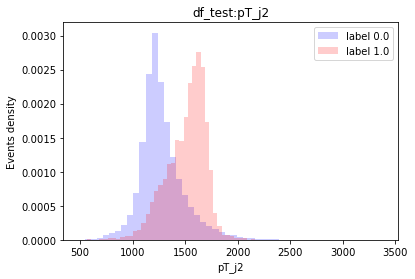

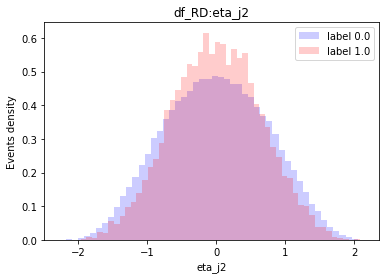

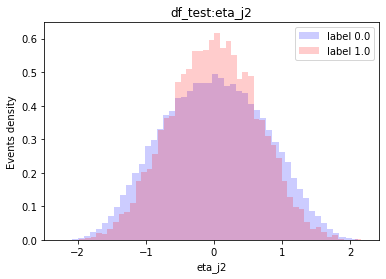

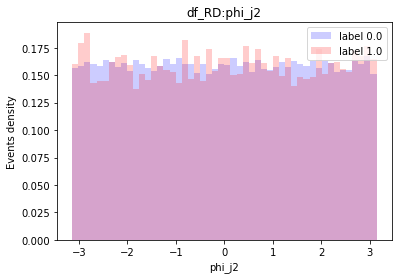

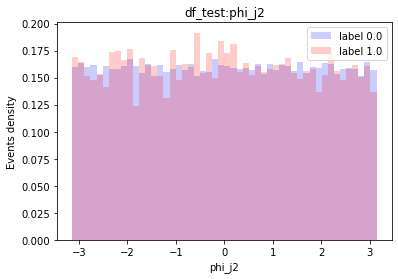

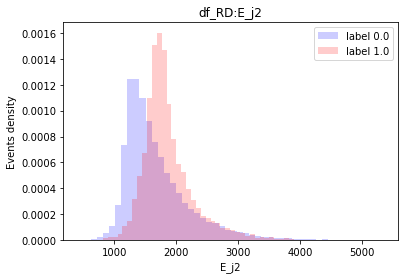

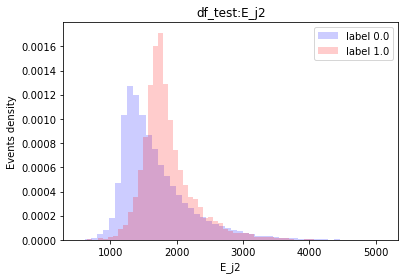

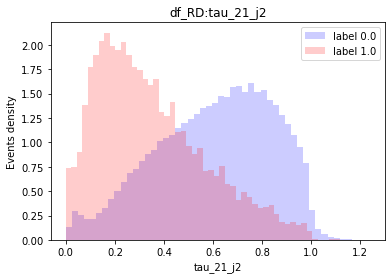

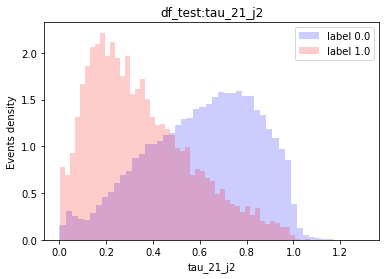

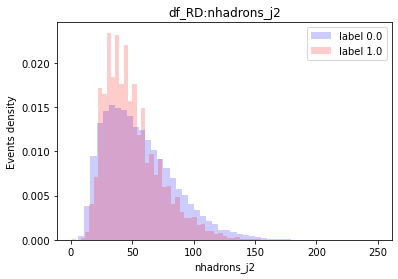

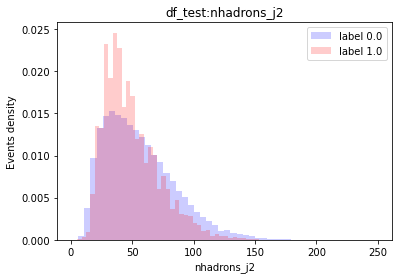

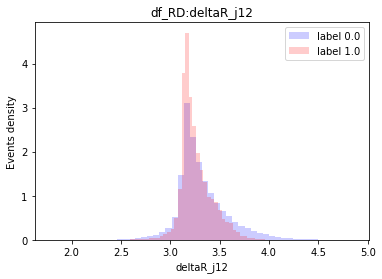

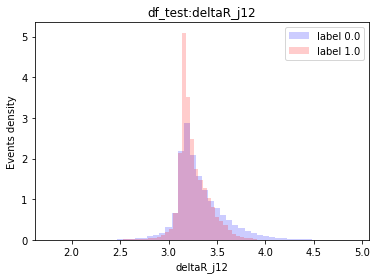

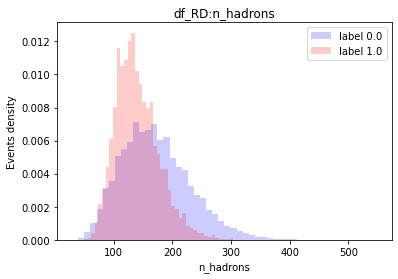

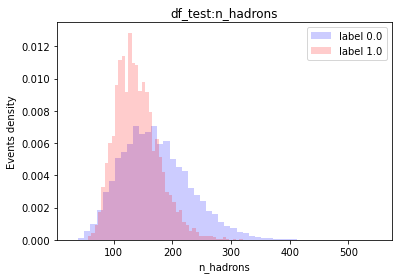

In [8]:
features = df_test.drop('label', axis=1).columns.tolist()

for feature in features:
    bkg_sig_hist(df_RD, variable=feature, label='label')
    plt.title('{}:{}'.format('df_RD',feature))
    bkg_sig_hist(df_test, variable=feature, label='label')
    plt.title('{}:{}'.format('df_test',feature))
    plt.show()

## Defining stuff for the pipeline

In [9]:
# Classifier class to save the output

class classifier:
    def __init__(self, name, score, pred, label):
        self.name = name
        self.score = score
        self.pred = pred       
        self.label = label
    #def numeric_metrics()
        
    def rejection(self):
        rejection_plot(self.name, self.label, self.score)
        plt.show()
        
    def inverse_roc(self):
        inverse_roc_plot(self.name, self.label, self.score)
        plt.show()
    
    def significance(self):
        significance_plot(self.name, self.label, self.score)
        plt.show()
        
    def precision_recall(self):
        precision_recall_plot(self.name, self.label, self.score)
        plt.show()

In [10]:
# Tensorflow classifier
def TensorflowClassifier(input_shape):

    # Creating the model
    # Here are the layers with batch normalization, the drop out rate and the activations
    '''
    model = keras.Sequential([
        layers.BatchNormalization(input_shape=input_shape),
        layers.Dense(512, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),   
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(128, activation='relu'),   
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(256, activation='relu'),   
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(512, activation='relu'),   
        layers.BatchNormalization(),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid'),
    ])
    '''
    model = keras.Sequential([
    layers.BatchNormalization(input_shape=input_shape),
    layers.Dense(512, activation='relu'),
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(512, activation='relu'),   
    layers.BatchNormalization(),
    layers.Dropout(0.3),
    layers.Dense(1, activation='sigmoid'),
    ])

    # Choosing the optimizer
    # Binary crossentropy for binary classification
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['binary_accuracy'],)
    
    return model

In [11]:
# Training and evaluation functions
def training_pipeline(X_train, y_train, X_test, y_test, classifiers, dimension_reduction=None):
    
    models = []

    for scaler, clf in tqdm(classifiers):
        
        name = clf.__class__.__name__

        if name == 'Sequential' :
            name = 'TensorflowClassifier'
            # Scaling the data
            X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
            X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])
            # Getting model
            model = clf
            model.summary()
            # We use early stop to prevent the model from overfitting
            early_stopping = keras.callbacks.EarlyStopping(
                patience=20,
                min_delta=0.001,
                restore_best_weights=True,
            )
            # Training the model
            model.fit(
            X_train, y_train,
            validation_data=(X_test, y_test),
            batch_size=512,
            epochs=200,
            callbacks=[early_stopping])
  
            model.save('../../data/models/tf_model.h5')

        # For tensorflow the training is different
        else:
            
             # Simple pipeline
            if dimension_reduction is None:
                model = Pipeline(steps=[('ss', scaler), ('clf', clf)])
            else:
                model = Pipeline(steps=[('ss', scaler), ('dr', dimension_reduction), ('clf', clf)])

            # Training the model
            model.fit(X_train, y_train) 
            
            # Saving into a list
            models.append((name,model))

    pickle.dump(models, open('sklearn_models.sav', 'wb'))
    print('Models saved') 
    

def evaluate_pipeline(X_test, y_test, models):
   # To save the output
    clfs = []
    
    for name, model in tqdm(models):
        
        if name != 'TensorflowClassifier':
            # Getting the prediction
            y_pred = model.predict(X_test)
            
            # Probability or distances
            try: 
                y_score = model.predict_proba(X_test)

                clfs.append(classifier(name, y_score[:,1], y_pred, y_test))
            except: 
                # KMeans doesn't have a probability, so here we get 
                # the distances to each cluster
                y_score = model.transform(X_test)
                # The score for KMeans is defined differently
                norm = np.linalg.norm(y_score[:,1])
                clfs.append(classifier(name, 1-y_score[:,1]/norm, y_pred, y_test))
        
        # For tensorflow the prediction is done differently
        else:
            y_score = model.predict(X_test)
            # Getting the threshold to make class predictions (0 or 1)
            threshold = optimal_threshold(y_test, y_score)
            y_pred = (model.predict(X_test) > threshold).astype("int32")
            clfs.append(classifier(name, y_score, y_pred, y_test))
    
    return clfs

## Training and comparing
I'll compare the metrics when training on both datasets
### df_RD

In [12]:
# Separating the features from the label
X, y = separate_data(df_RD, standarize=False)
# Splitting in training and testis sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [13]:
# Listing the classifiers to compare
classifiers = [(MinMaxScaler(feature_range=(-1,1)), TensorflowClassifier(input_shape = [X_train.shape[1]])),
                (StandardScaler(), RandomForestClassifier(random_state=1)),
                (RobustScaler(), GradientBoostingClassifier(random_state=4)),
                (RobustScaler(), QuadraticDiscriminantAnalysis()), 
                (StandardScaler(), MLPClassifier(random_state=7)),
                (StandardScaler(), KMeans(n_clusters=2, random_state=15)),
                ]

In [14]:
training_pipeline(X_train, y_train, X_test, y_test, classifiers)

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (BatchN  (None, 14)               56        
 ormalization)                                                   
                                                                 
 dense (Dense)               (None, 512)               7680      
                                                                 
 batch_normalization_1 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_2 (Batc  (None, 512)              2

137/137 [==============================] - 14s 106ms/step - loss: 0.1091 - binary_accuracy: 0.9590 - val_loss: 0.1329 - val_binary_accuracy: 0.9513
Epoch 28/200
137/137 [==============================] - 14s 106ms/step - loss: 0.1103 - binary_accuracy: 0.9590 - val_loss: 0.1406 - val_binary_accuracy: 0.9477
Epoch 29/200
137/137 [==============================] - 14s 106ms/step - loss: 0.1083 - binary_accuracy: 0.9589 - val_loss: 0.1289 - val_binary_accuracy: 0.9505
Epoch 30/200
137/137 [==============================] - 14s 106ms/step - loss: 0.1058 - binary_accuracy: 0.9608 - val_loss: 0.1325 - val_binary_accuracy: 0.9505
Epoch 31/200
137/137 [==============================] - 15s 107ms/step - loss: 0.1065 - binary_accuracy: 0.9593 - val_loss: 0.1325 - val_binary_accuracy: 0.9509
Epoch 32/200
137/137 [==============================] - 14s 106ms/step - loss: 0.1061 - binary_accuracy: 0.9603 - val_loss: 0.1344 - val_binary_accuracy: 0.9510
Epoch 33/200
137/137 [=========================

100%|██████████| 6/6 [12:38<00:00, 126.36s/it]

Models saved


In [15]:
models_file = pickle.load(open('sklearn_models.sav', 'rb'))
tf_model = load_model('../../data/models/tf_model.h5')
models_file.append(('TensorflowClassifier', tf_model))

In [16]:
clfs = evaluate_pipeline(X_test, y_test, models_file)

100%|██████████| 6/6 [00:11<00:00,  1.91s/it]


In [17]:
names = [clf.name for clf in clfs]
scores = [clf.score for clf in clfs]
preds = [clf.pred for clf in clfs]      
labels = [clf.label.to_numpy() for clf in clfs]

names

['RandomForestClassifier',
 'GradientBoostingClassifier',
 'QuadraticDiscriminantAnalysis',
 'MLPClassifier',
 'KMeans',
 'TensorflowClassifier']

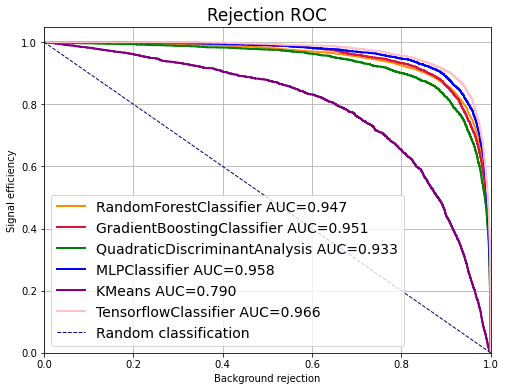

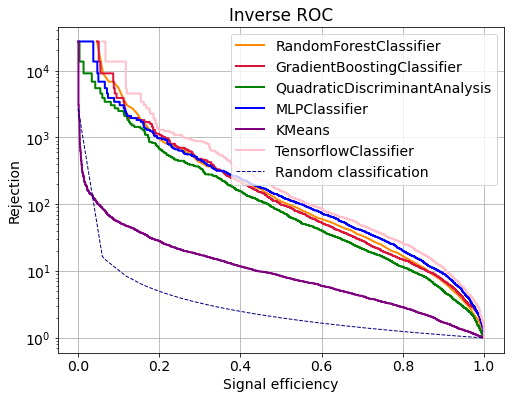

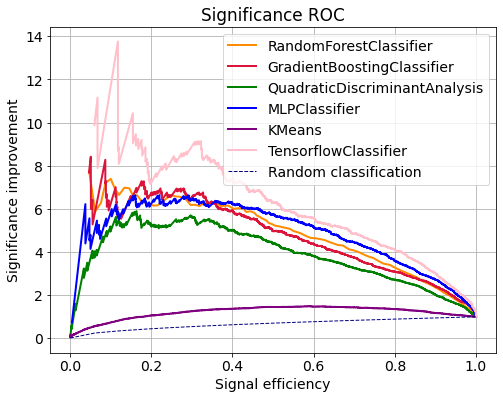

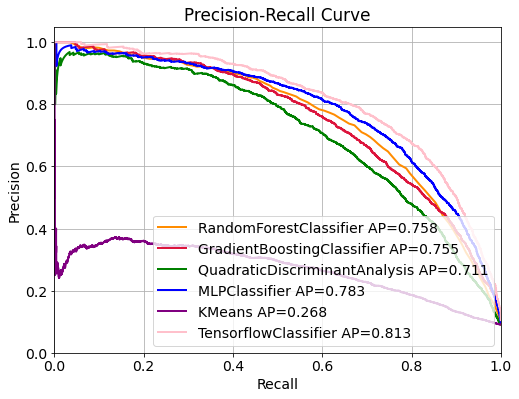

In [18]:
from benchtools.src.metrictools import performance_metrics, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

rejection_plot(names=names, labels=labels, probs=scores)
plt.show()

inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.show()

significance_plot(names=names, labels=labels, probs=scores)
plt.show()

precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()

### df_test

In [19]:
# Separating the features from the label
X, y = separate_data(df_test, standarize=False)
# Splitting in training and testis sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

In [20]:
# Listing the classifiers to compare
classifiers = [(MinMaxScaler(feature_range=(-1,1)), TensorflowClassifier(input_shape = [X_train.shape[1]])),
                (StandardScaler(), RandomForestClassifier(random_state=1)),
                (RobustScaler(), GradientBoostingClassifier(random_state=4)),
                (RobustScaler(), QuadraticDiscriminantAnalysis()), 
                (StandardScaler(), MLPClassifier(random_state=7)),
                (StandardScaler(), KMeans(n_clusters=2, random_state=15)),
                ]

In [21]:
training_pipeline(X_train, y_train, X_test, y_test, classifiers)

  0%|          | 0/6 [00:00<?, ?it/s]

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization_6 (Batc  (None, 14)               56        
 hNormalization)                                                 
                                                                 
 dense_6 (Dense)             (None, 512)               7680      
                                                                 
 batch_normalization_7 (Batc  (None, 512)              2048      
 hNormalization)                                                 
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_7 (Dense)             (None, 512)               262656    
                                                                 
 batch_normalization_8 (Batc  (None, 512)             

137/137 [==============================] - 14s 102ms/step - loss: 0.1056 - binary_accuracy: 0.9596 - val_loss: 0.1288 - val_binary_accuracy: 0.9494
Epoch 30/200
137/137 [==============================] - 14s 103ms/step - loss: 0.1029 - binary_accuracy: 0.9607 - val_loss: 0.1256 - val_binary_accuracy: 0.9520
Epoch 31/200
137/137 [==============================] - 14s 103ms/step - loss: 0.1039 - binary_accuracy: 0.9604 - val_loss: 0.1234 - val_binary_accuracy: 0.9538
Epoch 32/200
137/137 [==============================] - 14s 103ms/step - loss: 0.1029 - binary_accuracy: 0.9609 - val_loss: 0.1300 - val_binary_accuracy: 0.9490
Epoch 33/200
137/137 [==============================] - 14s 105ms/step - loss: 0.1018 - binary_accuracy: 0.9610 - val_loss: 0.1319 - val_binary_accuracy: 0.9503
Epoch 34/200
137/137 [==============================] - 15s 108ms/step - loss: 0.1013 - binary_accuracy: 0.9611 - val_loss: 0.1249 - val_binary_accuracy: 0.9530 - loss: 
Epoch 35/200
137/137 [================

 67%|██████▋   | 4/6 [10:43<03:11, 95.86s/it] C:\Users\maria\anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
100%|██████████| 6/6 [12:15<00:00, 122.52s/it]

Models saved


In [22]:
models_file = pickle.load(open('sklearn_models.sav', 'rb'))
tf_model = load_model('../../data/models/tf_model.h5')
models_file.append(('TensorflowClassifier', tf_model))

In [23]:
clfs = evaluate_pipeline(X_test, y_test, models_file)

100%|██████████| 6/6 [00:11<00:00,  1.84s/it]


In [24]:
names = [clf.name for clf in clfs]
scores = [clf.score for clf in clfs]
preds = [clf.pred for clf in clfs]      
labels = [clf.label.to_numpy() for clf in clfs]

names

['RandomForestClassifier',
 'GradientBoostingClassifier',
 'QuadraticDiscriminantAnalysis',
 'MLPClassifier',
 'KMeans',
 'TensorflowClassifier']

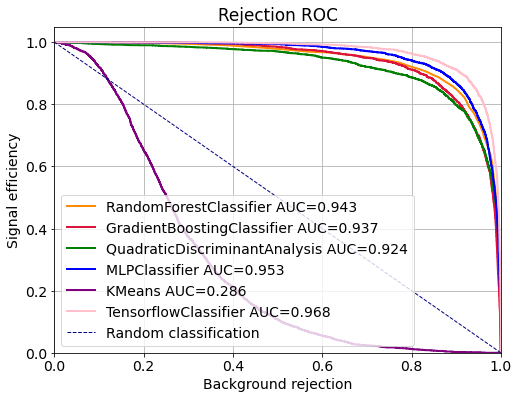

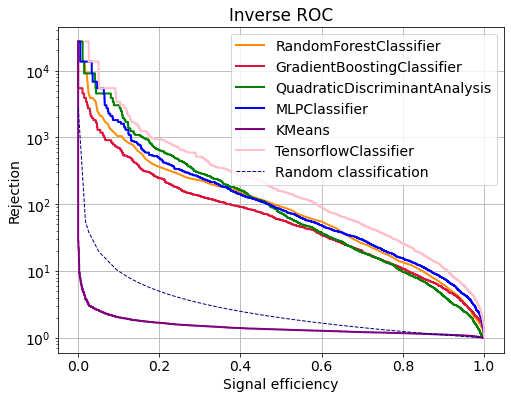

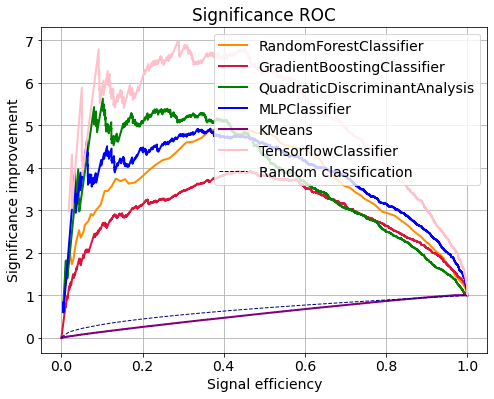

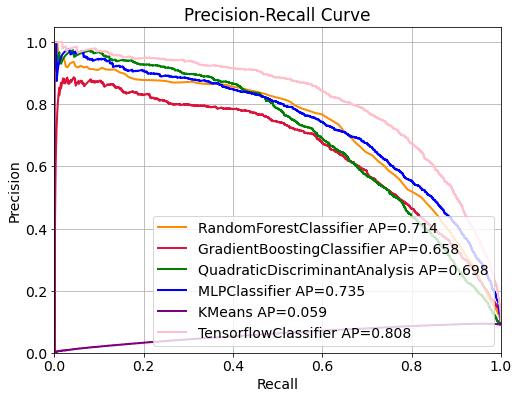

In [25]:
from benchtools.src.metrictools import performance_metrics, rejection_plot, inverse_roc_plot, significance_plot, precision_recall_plot

rejection_plot(names=names, labels=labels, probs=scores)
plt.show()

inverse_roc_plot(names=names, labels=labels, probs=scores)
plt.show()

significance_plot(names=names, labels=labels, probs=scores)
plt.show()

precision_recall_plot(names=names, labels=labels, probs=scores)
plt.show()